In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config=config)


In [2]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data_10.json"
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error")

    plt.show()
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

# load data
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [3]:
# create train/test split
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

Data succesfully loaded!


In [4]:
# build network topology
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [5]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.save_weights('model.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

In [6]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)


Epoch 1/30
188/188 [==============================] - 2s 9ms/step - loss: 2.4389 - accuracy: 0.2203 - val_loss: 1.9182 - val_accuracy: 0.3173
Epoch 2/30
188/188 [==============================] - 1s 7ms/step - loss: 1.9289 - accuracy: 0.3302 - val_loss: 1.6375 - val_accuracy: 0.4160
Epoch 3/30
188/188 [==============================] - 1s 7ms/step - loss: 1.7113 - accuracy: 0.3949 - val_loss: 1.4697 - val_accuracy: 0.4840
Epoch 4/30
188/188 [==============================] - 1s 6ms/step - loss: 1.5698 - accuracy: 0.4376 - val_loss: 1.3708 - val_accuracy: 0.5180
Epoch 5/30
188/188 [==============================] - 2s 9ms/step - loss: 1.4883 - accuracy: 0.4609 - val_loss: 1.2910 - val_accuracy: 0.5393
Epoch 6/30
188/188 [==============================] - 1s 7ms/step - loss: 1.4020 - accuracy: 0.4971 - val_loss: 1.2505 - val_accuracy: 0.5540
Epoch 7/30
188/188 [==============================] - 1s 7ms/step - loss: 1.3410 - accuracy: 0.5151 - val_loss: 1.2129 - val_accuracy: 0.5740
Epoch 

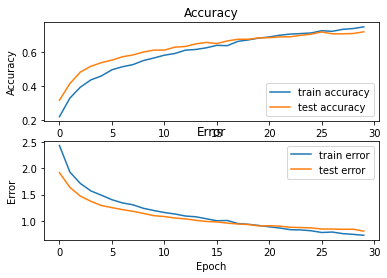

In [7]:
plot_history(history)

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 0s - loss: 0.8248 - accuracy: 0.7163

Test accuracy: 0.7162865400314331


In [10]:
predictions = model.predict(X_test)

In [13]:
n = 9
print(np.argmax(predictions[n]))
print(y_test[n])

9
9
